# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn
%matplotlib inline

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape

In [ ]:
y.shape

# Get Data

In [2]:
data = pd.read_csv("D:\IEEE\Machine\mnist_784.csv")

In [3]:
data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [4]:
X = data.iloc[:, :-1].values
y = data.iloc[:,-1].values

In [5]:
y.shape

(70000,)

In [6]:
X.shape

(70000, 784)

There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black).

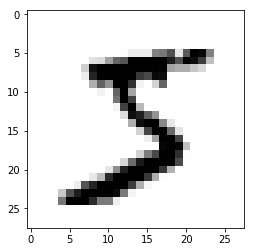

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.show()

In [8]:
y[0]

5

In [9]:
y = y.astype(np.uint8)

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5.

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measure

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we
will spend a large part of this chapter on this topic.

## Cross Validation

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion
matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
matrix.

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents
a predicted class. The first row of this matrix considers non-5 images (the negative
class): 53,057 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 1,522 were wrongly classified as 5s (false positives).

The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric. An interesting one to look at is the accuracy of the positive predictions;
this is called the precision of the classifier

precision = TP / (TP + FP).

TP is the number of true positives, and FP is the number of false positives.
A trivial way to have perfect precision is to make one single positive prediction and
ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the
classifier would ignore all but one positive instance. So precision is typically used
along with another metric named recall, also called sensitivity or true positive rate

(TPR): this is the ratio of positive instances that are correctly detected by the classifier

recall = TP / (TP + FN)

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

To compute the F1 score, simply call the f1_score() function:

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall Tradeoff

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

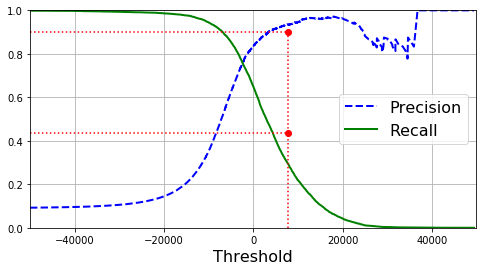

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plt.figure(figsize=(8, 4))                      # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([7813, 7813], [0., 0.9], "r:")         # Not shown
plt.plot([-50000, 7813], [0.9, 0.9], "r:")      # Not shown
plt.plot([-50000, 7813], [0.4368, 0.4368], "r:")# Not shown
plt.plot([7813], [0.9], "ro")                   # Not shown
plt.plot([7813], [0.4368], "ro")                # Not shown
plt.show()

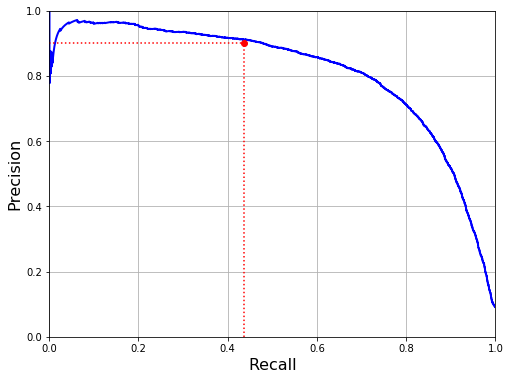

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will
probably want to select a precision/recall tradeoff just before that drop—for example,
at around 60% recall. But of course the choice depends on your project.

So let’s suppose you decide to aim for 90% precision. You look up the first plot and
find that you need to use a threshold of about 8,000. To be more precise you can
search for the lowest threshold that gives you at least 90% precision (np.argmax()
will give us the first index of the maximum value, which in this case means the first
True value):

In [33]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [34]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [37]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Great, you have a 90% precision classifier ! As you can see, it is fairly easy to create a
classifier with virtually any precision you want: just set a high enough threshold, and
you’re done. Hmm, not so fast. A high-precision classifier is not very useful if its
recall is too low!

##### If someone says “let’s reach 99% precision,” you should ask, “at what recall?”

## train RandomForestClassifier 

In [39]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [40]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [41]:
recall_score(y_train_5, y_train_pred_forest)


0.8662608374838591

## Multiclass classifier

In [46]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)

In [50]:
svm_clf.fit(X_train, y_train) # y_train, not y_train_5

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [51]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [52]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [53]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [55]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [56]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [58]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)